In [1]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.layers import Convolution1D
from keras.layers import MaxPooling1D
from keras.layers import Embedding
from keras.layers import ThresholdedReLU
from keras.layers import Dropout
from keras.callbacks import TensorBoard
import gc
import matplotlib.pyplot as plt
import json
import tensorflow as tf
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
class Data(object):
    """
    Class to handle loading and processing of raw datasets.
    """

    def __init__(self,
                 training_data_x,
                 training_labels_y,
                 alphabet="abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}",
                 input_size=1014, num_of_classes=12):
        """
        Initialization of a Data object.

        Args:
            data_source (str): Raw data file path
            alphabet (str): Alphabet of characters to index
            input_size (int): Size of input features
            num_of_classes (int): Number of classes in data
        """
        self.alphabet = alphabet
        self.alphabet_size = len(self.alphabet)
        self.dict = {}  # Maps each character to an integer
        self.no_of_classes = num_of_classes
        for index, char in enumerate(self.alphabet):
            self.dict[char] = index + 1
        self.length = input_size
        self.training_data_x = training_data_x
        self.training_labels_y = training_labels_y

    def load_data(self):
        """
        Load raw data from the source file into data variable.

        Returns: None

        """
        data = []
        f_x = open(self.training_data_x, 'r')
        f_y = np.loadtxt(self.training_labels_y, dtype='int64')
        lines = f_x.readlines()
        for y, x in zip(f_y, lines):
            data.append((y, x))
        self.data = np.array(data)
        print("########## Data loaded ##########")

    def get_all_data(self):
        """
        Return all loaded data for training the network from data variable.

        Returns:
            (np.ndarray) Data transformed from raw to indexed form with associated one-hot label.

        """
        data_size = len(self.data)
        start_index = 0
        end_index = data_size
        batch_texts = self.data[start_index:end_index]
        batch_indices = []
        one_hot = np.eye(self.no_of_classes, dtype='int64')
        classes = []
        for c, s in batch_texts:
            batch_indices.append(self.str_to_indexes(s))
            c = int(c) - 1
            classes.append(one_hot[c])
        return np.asarray(batch_indices, dtype='int64'), np.asarray(classes)

    def str_to_indexes(self, s):
        """
        Convert a string to character indexes based on character dictionary.

        Args:
            s (str): String to be converted to indexes

        Returns:
            s1hot (np.ndarray): Indexes of characters in s

        """
        s = s.lower()
        max_length = min(len(s), self.length)
        s1hot = np.zeros(self.length, dtype='int64')
        for i in range(1, max_length + 1):
            c = s[-i]
            if c in self.dict:
                s1hot[i - 1] = self.dict[c]
        return s1hot

In [3]:
# load config
config = json.load(open("./config.json"))

In [7]:
# Load training data
training_data = Data(training_data_x=config["data"]["training_data_x"],
                     training_labels_y = config["data"]["training_labels_y"],
                        alphabet=config["data"]["alphabet"],
                        input_size=config["data"]["input_size"],
                        num_of_classes=config["data"]["num_of_classes"])
training_data.load_data()
training_inputs, training_labels = training_data.get_all_data()

# Load validation data
heldout_data = Data(training_data_x=config["data"]["validation_data_x"],
                     training_labels_y = config["data"]["validation_labels_y"],
                        alphabet=config["data"]["alphabet"],
                        input_size=config["data"]["input_size"],
                        num_of_classes=config["data"]["num_of_classes"])
heldout_data.load_data()
heldout_inputs, heldout_labels = heldout_data.get_all_data()

########## Data loaded ##########
########## Data loaded ##########


In [5]:
len(training_inputs), len(heldout_inputs)

(30000, 2513)

In [6]:
class ModelClass(object):
    """
    Class to implement the Character Level Convolutional Neural Network for Text Classification,
    as described in Zhang et al., 2015 (http://arxiv.org/abs/1509.01626)
    """
    def __init__(self, input_size, alphabet_size, embedding_size,
                 conv_layers, fully_connected_layers, num_of_classes,
                 threshold, dropout_p,
                 optimizer='adam', loss='categorical_crossentropy'):
        """
        Initialization for the Character Level CNN model.

        Args:
            input_size (int): Size of input features
            alphabet_size (int): Size of alphabets to create embeddings for
            embedding_size (int): Size of embeddings
            conv_layers (list[list[int]]): List of Convolution layers for model
            fully_connected_layers (list[list[int]]): List of Fully Connected layers for model
            num_of_classes (int): Number of classes in data
            threshold (float): Threshold for Thresholded ReLU activation function
            dropout_p (float): Dropout Probability
            optimizer (str): Training optimizer
            loss (str): Loss function
        """
        self.input_size = input_size
        self.alphabet_size = alphabet_size
        self.embedding_size = embedding_size
        self.conv_layers = conv_layers
        self.fully_connected_layers = fully_connected_layers
        self.num_of_classes = num_of_classes
        self.threshold = threshold
        self.dropout_p = dropout_p
        self.optimizer = optimizer
        self.loss = loss
        self._build_model()  # builds self.model variable

    def _build_model(self):
        """
        Build and compile the Character Level CNN model

        Returns: None

        """
        # Input layer
        inputs = Input(shape=(self.input_size,), name='sent_input', dtype='int64')
        # Embedding layers
        x = Embedding(self.alphabet_size + 1, self.embedding_size, input_length=self.input_size)(inputs)
        # Convolution layers
        for cl in self.conv_layers:
            x = Convolution1D(cl[0], cl[1])(x)
            x = ThresholdedReLU(self.threshold)(x)
            if cl[2] != -1:
                x = MaxPooling1D(cl[2])(x)
        x = Flatten()(x)
        # Fully connected layers
        for fl in self.fully_connected_layers:
            x = Dense(fl)(x)
            x = ThresholdedReLU(self.threshold)(x)
            x = Dropout(self.dropout_p)(x)
        # Output layer
        predictions = Dense(self.num_of_classes, activation='softmax')(x)
        # Build and compile model
        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer=self.optimizer, loss=self.loss)
        self.model = model
        print("#########  model built  ##########")
        self.model.summary()

    def train(self, training_inputs, training_labels,
              validation_split,
              epochs, batch_size, checkpoint_every=100):
        """
        Training function

        Args:
            training_inputs (numpy.ndarray): Training set inputs
            training_labels (numpy.ndarray): Training set labels
            validation_split (float): Fraction of training data used for validation
            epochs (int): Number of training epochs
            batch_size (int): Batch size
            checkpoint_every (int): Interval for logging to Tensorboard

        Returns: None

        """
        # Start training
        print("############# Training model started #############: ")
        early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=3,
                                       verbose=0,
                                       mode='auto')
        self.model.fit(training_inputs, training_labels,
                       validation_split=validation_split,
                       shuffle=True,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1,
                       callbacks=[early_stopping])

    def test(self, testing_inputs, testing_labels, batch_size):
        """
        Testing function

        Args:
            testing_inputs (numpy.ndarray): Testing set inputs
            testing_labels (numpy.ndarray): Testing set labels
            batch_size (int): Batch size

        Returns: None

        """
        # Evaluate inputs
        score = self.model.evaluate(testing_inputs, testing_labels, batch_size=batch_size, verbose=1)
        gc.collect()
        print('Score of the model= {}'.format(score))
        #self.model.predict(testing_inputs, batch_size=batch_size, verbose=1)


In [7]:
model = ModelClass(input_size=config["data"]["input_size"],
                   alphabet_size=config["data"]["alphabet_size"],
                   embedding_size=config[config["model"]]["embedding_size"],
                   conv_layers=config[config["model"]]["conv_layers"],
                   fully_connected_layers=config[config["model"]]["fully_connected_layers"],
                   num_of_classes=config["data"]["num_of_classes"],
                   threshold=config[config["model"]]["threshold"],
                   dropout_p=config[config["model"]]["dropout_p"],
                   optimizer=config[config["model"]]["optimizer"],
                   loss=config[config["model"]]["loss"])

#########  model built  ##########
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sent_input (InputLayer)      (None, 1014)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1014, 128)         8960      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1008, 256)         229632    
_________________________________________________________________
thresholded_re_lu_1 (Thresho (None, 1008, 256)         0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 336, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 330, 256)          459008    
_________________________________________________________________
thresholded_re_lu_2 (Thresho (None, 330, 

In [8]:
model.train(training_inputs=training_inputs,
            training_labels=training_labels,
            validation_split=config["training"]["validation_split"],
            epochs= 15, #config["training"]["epochs"],
            batch_size=config["training"]["batch_size"],
            checkpoint_every=config["training"]["checkpoint_every"])

############# Training model started #############: 
Train on 24000 samples, validate on 6000 samples
Epoch 1/15
24000/24000 [==============================] - 67s - loss: 2.4045 - val_loss: 2.3649
Epoch 2/15
24000/24000 [==============================] - 53s - loss: 2.3501 - val_loss: 2.2620
Epoch 3/15
24000/24000 [==============================] - 53s - loss: 2.2207 - val_loss: 2.0999
Epoch 4/15
24000/24000 [==============================] - 53s - loss: 2.0828 - val_loss: 1.9607
Epoch 5/15
24000/24000 [==============================] - 53s - loss: 1.9302 - val_loss: 1.7922
Epoch 6/15
24000/24000 [==============================] - 53s - loss: 1.7654 - val_loss: 1.6453
Epoch 7/15
24000/24000 [==============================] - 53s - loss: 1.6384 - val_loss: 1.5248
Epoch 8/15
24000/24000 [==============================] - 52s - loss: 1.5378 - val_loss: 1.4793
Epoch 9/15
24000/24000 [==============================] - 52s - loss: 1.4728 - val_loss: 1.4332
Epoch 10/15
24000/24000 [=========

In [9]:
model.model.save(r'trained_model')

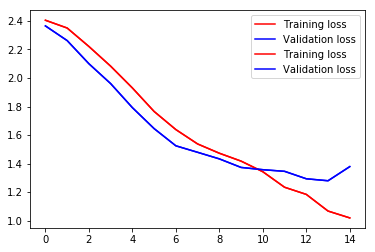

In [16]:
plt.plot(model.model.history.history['loss'],'r', label = 'Training loss')
plt.plot(model.model.history.history['val_loss'],'b', label = 'Validation loss')
plt.legend()
plt.show()
plt.savefig('plot.png')

## Use heldout data to determine expected accuracy and text data to predict classes

In [4]:
# Load test data
test_data = Data(training_data_x=config["data"]["test_x"],
                     training_labels_y = config["data"]["training_labels_y"],
                        alphabet=config["data"]["alphabet"],
                        input_size=config["data"]["input_size"],
                        num_of_classes=config["data"]["num_of_classes"])
test_data.load_data()
test_inputs, _ = test_data.get_all_data()

########## Data loaded ##########


In [5]:
# predict class labels of test data
from keras.models import load_model
m = load_model('trained_model')
labels = m.predict(test_inputs)
classes = np.argmax(labels,1)
np.savetxt('ytest', classes, fmt='%i')

In [8]:
# test the model on the heldout data
# this will give the predicted accuracy of the model on the actual test data
y=m.predict(x=heldout_inputs, verbose=1)
acc, acc_op = tf.metrics.accuracy(labels=tf.argmax(heldout_labels, 1), predictions=tf.argmax(y,1))
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
tf.local_variables_initializer().run()
print(sess.run([acc, acc_op]))
print(sess.run([acc]))

2513/2513 [==============================] - 2s     
[0.0, 0.59450853]
[0.59450853]


# Answers:
### Please refer to README.md for the explaination and other details
### First of all, due to limited compute power and time, I only trained for 15 epochs. 
### Trained on floyd hub servers
### Configuration of the network and training parameters can be found in the config.json file
### Expected accuracy on the test data = 59.4%, Accuracy will improve with higher number of epochs
### Predicted class labels of the test data can be found in "ytest.txt"
